# Table of Contents
1. [Data](#Data)
2. [Load data](#Load-data)
3. [Clean and check data](#Clean-and-check-data)
4. [Distribution of some features](#Distribution-of-some-features)
5. [Derive time features and create target](#Derive-time-features-and-create-target)
6. [Flatten windows and create feature dictionary](#Flatten-windows-and-create-feature-dictionary)
7. [Screening with correlation and decision trees](#Screening-with-correlation-and-decision-trees)
8. [Baseline return](#Baseline-return)
9. [Pytorch](#Pytorch)
10. [TODO](#TODO)
11. [Appendix](#Appendix)


## Data
 
The data consists of candlestick windows, where each candlestick represents one minute. There are 26 candlesticks for each window and the 21st candlestick is a "signal candle" that is either up more than 4% or down more than -4%. The windows were collected for stocks that had satisfied certain thresholds for volume, price, and (high-low)/low. For more details on the data, see the appendix.

## Load data

In [1]:
import os
import pandas as pd
import numpy as np
import time

folder = "windows"
windows_csv_names = os.listdir(folder)
windows = []

start_time = time.time()
for i, f in enumerate(windows_csv_names, start=1):
    w_df = pd.read_csv(os.path.join(folder, f))
    windows.append(w_df)
    
    if i % 5000 == 0:
        print(f"{i}/ {len(windows_csv_names)} CSV files loaded")
end_time = time.time()

print(f"Number of windows: {len(windows)}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

5000/ 23163 CSV files loaded
10000/ 23163 CSV files loaded
15000/ 23163 CSV files loaded
20000/ 23163 CSV files loaded
Number of windows: 23163
Time taken: 93.18 seconds


## Clean and check data

In [2]:
# Window parameters
N_CANDLES = 26 # Candles per window
N_CANDLES_BEFORE = 20 # Candles before signal candle
N_CANDLES_AFTER = 5 # Candles after signal candle
I_SIGNAL_CANDLE = N_CANDLES_BEFORE # Index signal candle
I_BUY_CANDLE = I_SIGNAL_CANDLE + 1 # Index buy candle
I_SELL_CANDLE = I_SIGNAL_CANDLE + N_CANDLES_AFTER # Index sell candle
SIGNAL_THR = 0.04 # Threshold for absolute value of (c-o)/o for signal candle

In [3]:
# Example window
windows[0]

,v,vw,o,c,h,l,t,n
0,16771,27.7948,27.755,27.7900,27.840,27.7550,2025-02-21 15:48:00,242
1,8376,27.7565,27.780,27.7650,27.790,27.7100,2025-02-21 15:49:00,124
2,16524,27.7511,27.765,27.7500,27.780,27.7300,2025-02-21 15:50:00,221
3,17292,27.7074,27.745,27.6900,27.750,27.6850,2025-02-21 15:51:00,246
4,19804,27.6796,27.700,27.6740,27.710,27.6500,2025-02-21 15:52:00,246
5,23903,27.6273,27.665,27.5850,27.703,27.5500,2025-02-21 15:53:00,250
6,43268,27.5722,27.575,27.5750,27.603,27.5430,2025-02-21 15:54:00,471
7,30053,27.4358,27.560,27.3300,27.560,27.3300,2025-02-21 15:55:00,328
8,42423,27.2484,27.320,27.2251,27.320,27.1600,2025-02-21 15:56:00,513
9,46713,27.2400,27.235,27.2900,27.300,27.2150,2025-02-21 15:57:00,566


In [4]:
# Convert time strings to timestamp
print(f"Type before: {type(windows[0]['t'][0])}")
for w_df in windows:
    w_df['t'] = pd.to_datetime(w_df['t'], errors='coerce')
print(f"Type after: {type(windows[0]['t'][0])}")

Type before: <class 'str'>
Type after: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [5]:
# Check missing values
has_na = [w_df.isna().any().any() for w_df in windows]
windows[0].isna()
total_with_na = sum(has_na)
print(f"{total_with_na} out of {len(windows)} windows have missing values.")

0 out of 23163 windows have missing values.


In [6]:
# Check length of windows
lengths = [len(w_df) for w_df in windows]
bad_length_idx = [i for i, L in enumerate(lengths) if L != N_CANDLES]
print(f"{len(bad_length_idx)} windows have incorrect length.")

0 windows have incorrect length.


In [7]:
# Check (close-open)/open for signal candle
signal_perc = [(w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE] for w_df in windows]
signal_perc = np.abs(np.array(signal_perc))
bad_signal_idx = [i for i, perc in enumerate(signal_perc) if perc < SIGNAL_THR]

print(f"Min: {np.min(signal_perc):.3f}")
print(f"Max: {np.max(signal_perc):.3f}")


print(f"{len(bad_signal_idx)} windows have bad signal candle.")

Min: 0.040
Max: 0.619
0 windows have bad signal candle.


In [8]:
# Check if dtypes are consistent
ref_dtypes = windows[0].dtypes

inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

12332 windows have inconsistent dtypes.


In [9]:
# Check first problem window
print(f"First problem window:\n{windows[inconsistent_idx[0]][:].dtypes}\n")
print(f"Reference window:\n{ref_dtypes}\n")

First problem window:
v            float64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object

Reference window:
v              int64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object



In [10]:
# Convert volume to int 
for i in inconsistent_idx:
    windows[i]['v'] = windows[i]['v'].round().astype('int64')

In [11]:
# Check inconsistent windows again
inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

0 windows have inconsistent dtypes.


In [12]:
# Check chronological order for windows
not_monotonic_time = np.array([not windows[i]['t'].is_monotonic_increasing for i in range(len(windows))])
print(f"{sum(not_monotonic_time)} windows have incorrect time order")    

0 windows have incorrect time order


## Distribution of some features

In [13]:
import matplotlib.pyplot as plt

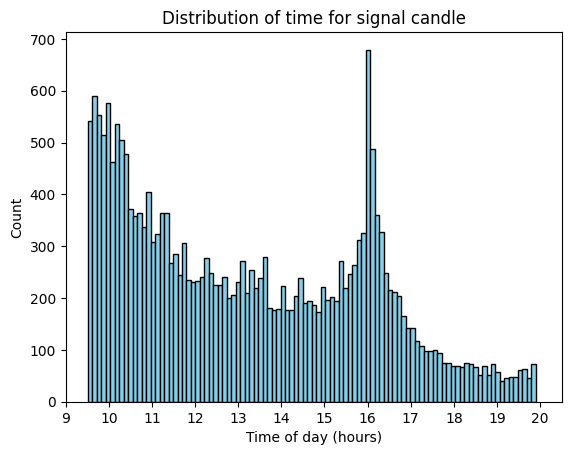

In [14]:
# Distribution of the time of day of signal candles
times_signal_h = []
for w_df in windows:
    time_signal_h = w_df['t'][I_SIGNAL_CANDLE]
    hours = time_signal_h.hour + time_signal_h.minute/60 + time_signal_h.second/3600
    times_signal_h.append(hours)


plt.hist(times_signal_h, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Time of day (hours)')
plt.ylabel('Count')
plt.title('Distribution of time for signal candle')
plt.xticks(range(8, 22, 1))
plt.xlim(9, 20.5)
plt.show()

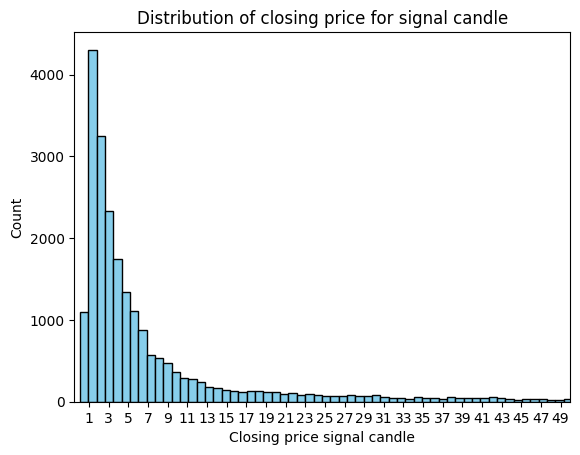

In [15]:
# Distribution of closing price for signal candle
price_signals = []
for w_df in windows:
    price_signals.append(w_df['c'][I_SIGNAL_CANDLE])
price_signals = np.array(price_signals)

plt.hist(price_signals, bins=1000, color='skyblue', edgecolor='black')
plt.xlabel('Closing price signal candle')
plt.ylabel('Count')
plt.title(f'Distribution of closing price for signal candle')
plt.xticks(range(1, 50, 2))
plt.xlim(-0.5, 50)
plt.show()

In [16]:
mean = np.mean(price_signals)   
median = np.median(price_signals) 
Min = np.min(price_signals)        
Max = np.max(price_signals)  
print(f"Summary of closing price for signal candle:")
print(f"Mean: {mean:.2f}, Median: {median:.2f}, Min: {Min:.2f}, Max: {Max:.2f}")

Summary of closing price for signal candle:
Mean: 14.49, Median: 3.74, Min: 0.07, Max: 849.25


In [17]:
# Total dollar amount last n_last candles
n_last = 5
dollar_amounts_last = []
for w_df in windows:
    start = I_SIGNAL_CANDLE - n_last
    end = I_SIGNAL_CANDLE
    avg_price = (w_df['c'][start:end] + w_df['o'][start:end]) / 2
    dollar_amount = (w_df['v'][start:end] * avg_price).sum()
    dollar_amounts_last.append(dollar_amount)

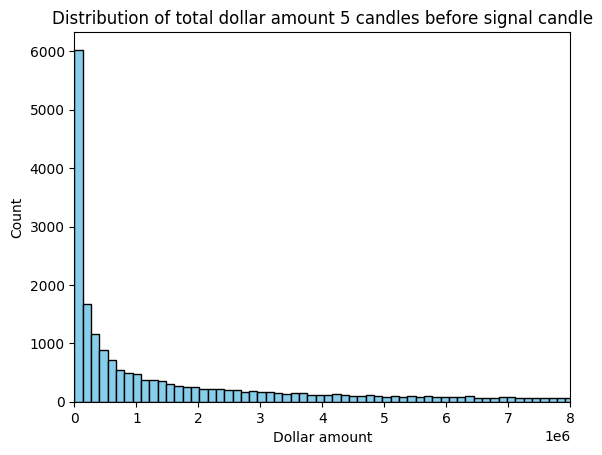

In [18]:
plt.hist(dollar_amounts_last, bins=7000, color='skyblue', edgecolor='black')
plt.xlabel('Dollar amount')
plt.ylabel('Count')
plt.title(f'Distribution of total dollar amount {n_last} candles before signal candle')
plt.xticks(range(0, 2_000_000_0, 1_000_000))
plt.xlim(-1, 8_000_000)
plt.show()

In [19]:
mean = np.mean(dollar_amounts_last)   
median = np.median(dollar_amounts_last) 
Min = np.min(dollar_amounts_last)        
Max = np.max(dollar_amounts_last) 
q01 = np.quantile(dollar_amounts_last, 0.1)  # 0.25 = 25%
print(f"Summary of total dollar amount {N_CANDLES_BEFORE} candles before signal candle:")
print(f"Mean: {mean:.0f}, Median: {median:.0f}, Min: {Min:.0f}, Max: {Max:.0f}, 0.1 quantile: {q01:.0f}")

Summary of total dollar amount 20 candles before signal candle:
Mean: 5313557, Median: 963047, Min: 167, Max: 939446084, 0.1 quantile: 22348


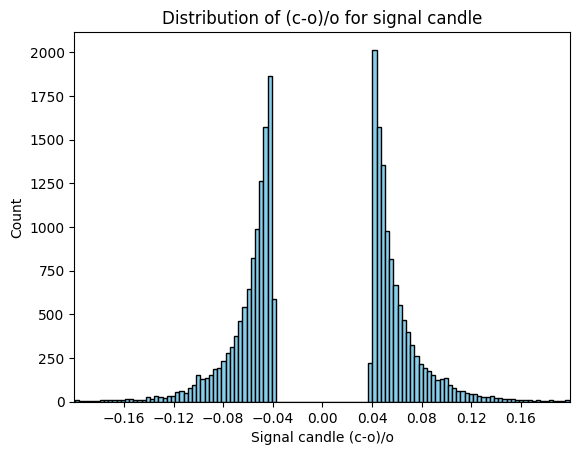

In [20]:
signal_candle_perc = []
for w_df in windows:
    signal_candle_perc.append((w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE])
signal_candle_perc = np.array(signal_candle_perc)
plt.hist(signal_candle_perc, bins=350, color='skyblue', edgecolor='black')
plt.xlabel('Signal candle (c-o)/o')
plt.ylabel('Count')
plt.title(f'Distribution of (c-o)/o for signal candle')
plt.xticks(np.arange(-0.16, 0.16 + 0.01, 0.04))
plt.xlim(-0.2, 0.2)
plt.show()

**Figure:** We can see that the windows are consciously chosen: every signal candle satisfies $|(c-o)/o| \geq 0.04$.

In [21]:
print("Signal candle (c-o)/o summary:")
print(f"Negative candles: min: {np.min(signal_candle_perc):.3f}, max: {np.max(signal_candle_perc[signal_candle_perc < 0]):.3f}")
print(f"Positive candles: min: {np.min(signal_candle_perc[signal_candle_perc > 0]):.3f}, max: {np.max(signal_candle_perc):.3f}")

Signal candle (c-o)/o summary:
Negative candles: min: -0.619, max: -0.040
Positive candles: min: 0.040, max: 0.565


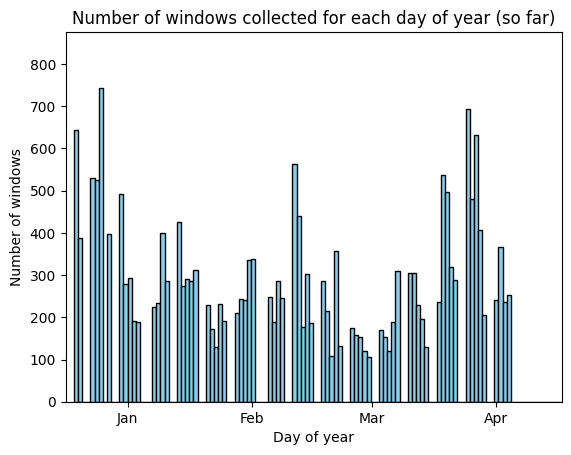

In [22]:
# Distribution of dayofyear of windows
dayofyears = []
for w_df in windows:
    dayofyears.append(w_df['t'].iloc[0].dayofyear)

plt.hist(dayofyears, bins=365, color='skyblue', edgecolor='black')
plt.xlabel('Day of year')
plt.ylabel('Number of windows')
plt.title(f'Number of windows collected for each day of year (so far)')
ticks = [15, 45, 74, 104]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr']
plt.xticks(ticks, month_labels)
plt.xlim(0, 120)
plt.show()

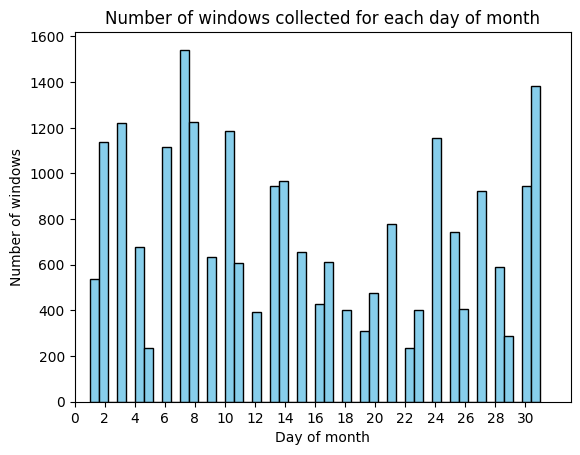

In [23]:
# Distribution of day of month of windows
dayofmonths = []
for w_df in windows:
    dayofmonths.append(w_df['t'].iloc[0].day)

plt.hist(dayofmonths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Day of month')
plt.ylabel('Number of windows')
plt.title(f'Number of windows collected for each day of month')
plt.xticks(np.arange(0, 31, 2))
plt.xlim(0, 33)
plt.show()

## Derive time features and create target

In [24]:
print(f"Number of rows up to and including signal candle: {len(windows[0].iloc[:I_BUY_CANDLE])}")
print(f"Number of columns: {len(windows[0].columns)}")
print(f"Number of raw features (nrows*ncols): {len(windows[0].iloc[:I_BUY_CANDLE]) * len(windows[0].dtypes)}")

Number of rows up to and including signal candle: 21
Number of columns: 8
Number of raw features (nrows*ncols): 168


In [25]:
windows[0].dtypes

v              int64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object

In [26]:
# Add return (continuous target) from open of buy candle to close of sell candle for each window
for w_df in windows:
    w_df['rtn'] = (w_df['c'][I_SELL_CANDLE] - w_df['o'][I_BUY_CANDLE]) / w_df['o'][I_BUY_CANDLE]

In [27]:
# Derive time features from 't'
for w_df in windows:
    w_df['minute'] = w_df['t'].dt.minute
    w_df['hour'] = w_df['t'].dt.hour
    w_df['dayofweek'] = w_df['t'].dt.dayofweek
    w_df['dayofmonth'] = w_df['t'].dt.day
    w_df['dayofyear'] = w_df['t'].dt.dayofyear
    w_df['month'] = w_df['t'].dt.month

    # Add 'halt' feature (if > 1min between signal candle and candle after (buy candle)
    w_df['halt'] = (w_df['t'].iloc[I_BUY_CANDLE] - w_df['t'].iloc[I_SIGNAL_CANDLE]) > pd.Timedelta(minutes=1)


print(f"Added time features (using windows[0].iloc[0]) as example):"
      f"\nminute: {windows[0]['minute'].iloc[0]}\nhour: {windows[0]['hour'].iloc[0]}"
      f"\ndayofweek: {windows[0]['dayofweek'].iloc[0]}\ndayofmonth: {windows[0]['dayofmonth'].iloc[0]}"
      f"\ndayofyear: {windows[0]['dayofyear'].iloc[0]}\nmonth: {windows[0]['month'].iloc[0]}"
      f"\nhalt: {windows[0]['halt'].iloc[0]}")

Added time features (using windows[0].iloc[0]) as example):
minute: 48
hour: 15
dayofweek: 4
dayofmonth: 21
dayofyear: 52
month: 2
halt: False


In [28]:
windows[0]

,v,vw,o,c,h,l,t,n,rtn,minute,hour,dayofweek,dayofmonth,dayofyear,month,halt
0,16771,27.7948,27.755,27.7900,27.840,27.7550,2025-02-21 15:48:00,242,-0.009385,48,15,4,21,52,2,False
1,8376,27.7565,27.780,27.7650,27.790,27.7100,2025-02-21 15:49:00,124,-0.009385,49,15,4,21,52,2,False
2,16524,27.7511,27.765,27.7500,27.780,27.7300,2025-02-21 15:50:00,221,-0.009385,50,15,4,21,52,2,False
3,17292,27.7074,27.745,27.6900,27.750,27.6850,2025-02-21 15:51:00,246,-0.009385,51,15,4,21,52,2,False
4,19804,27.6796,27.700,27.6740,27.710,27.6500,2025-02-21 15:52:00,246,-0.009385,52,15,4,21,52,2,False
5,23903,27.6273,27.665,27.5850,27.703,27.5500,2025-02-21 15:53:00,250,-0.009385,53,15,4,21,52,2,False
6,43268,27.5722,27.575,27.5750,27.603,27.5430,2025-02-21 15:54:00,471,-0.009385,54,15,4,21,52,2,False
7,30053,27.4358,27.560,27.3300,27.560,27.3300,2025-02-21 15:55:00,328,-0.009385,55,15,4,21,52,2,False
8,42423,27.2484,27.320,27.2251,27.320,27.1600,2025-02-21 15:56:00,513,-0.009385,56,15,4,21,52,2,False
9,46713,27.2400,27.235,27.2900,27.300,27.2150,2025-02-21 15:57:00,566,-0.009385,57,15,4,21,52,2,False


**Note:** Minute difference between rows doesn't have to be 1: candles with no volume are not included.

## Flatten windows and create feature dictionary

In [29]:
# Flatten windows
all_rows = []
skip_cols = ['rtn', 't', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'halt'] 

for w_df in windows:
    flattened = w_df.iloc[:I_BUY_CANDLE].drop(columns=skip_cols, errors='ignore').values.flatten(order='F')

    # variables that are constant in each window
    rtn_value = w_df['rtn'].iloc[0]
    dayofweek = w_df['dayofweek'].iloc[0]
    dayofmonth = w_df['dayofmonth'][0]
    dayofyear = w_df['dayofyear'].iloc[0]
    month = w_df['month'].iloc[0]
    halt = w_df['halt'].iloc[0]
    
    row = np.array([rtn_value] + list(flattened) + [dayofweek, dayofmonth, dayofyear, month, halt]) # flattened window

    all_rows.append(row)

n_full_cols = flattened.shape[0] # Number of columns for which all rows are used
assert n_full_cols % (N_CANDLES_BEFORE + 1) == 0

df_flattened_windows = pd.DataFrame(all_rows)  # directly from the list of lists

print(df_flattened_windows.shape)
print(f"Features per window: {df_flattened_windows.shape[1]} - 1")

(23163, 195)
Features per window: 195 - 1


In [30]:
# Create feature dictionary for flattened windows

headers_full_cols = ['v', 'vw', 'o', 'c', 'h', 'l', 'n', 'minute', 'hour']
feature_dict = {}

# First column
feature_dict[0] = 'rtn'

# Columns with whose all rows are used
for i in range(1, n_full_cols + 1):  
    if (i - 1) % (N_CANDLES_BEFORE + 1) == 0:
        # change header
        header = headers_full_cols[i // (N_CANDLES_BEFORE + 1)]
    candle = (i - 1) % (N_CANDLES_BEFORE + 1)
    feature_dict[i] = f"{header}_candle_{candle}"

# Columns with only one value
for i in range(len(skip_cols) - 2): # 'rtn' already first col, 't' is splitted to other time features
    feature_dict[i + n_full_cols + 1] = f"{skip_cols[i+2]}"

## Screening with correlation and decision trees

In [31]:
# Pearson and Spearman correlations for all columns vs first column (target)

pearsons = df_flattened_windows.corr(method='pearson')[0] 
spearmans = df_flattened_windows.corr(method='spearman')[0]

In [32]:
# Print top correlations

# Print settings
L_1 = 35 # left adjust first print
L_2 = 10 # left adjust second print

top_n_corr = 50

top_n_pear_abs = pearsons.abs().sort_values(ascending=False).head(top_n_corr)
top_n_pear = pearsons[top_n_pear_abs.index]

top_n_spear_abs = spearmans.abs().sort_values(ascending=False).head(top_n_corr)
top_n_spear = spearmans[top_n_spear_abs.index]

print("".ljust(4), f"Top {top_n_corr} Pearson:".ljust(L_1+15), f"Top {top_n_corr} Spearman:".ljust(12))

print("".ljust(L_1+5), "Pearson".ljust(L_1+15), "Spearman")
for i in range(top_n_corr):
    print(f"{i+1}".ljust(4), f"Column {top_n_pear.index[i]} ({feature_dict[top_n_pear.index[i]]})".ljust(L_1),\
          f"{top_n_pear.iloc[i]:.4f}".ljust(14),\
          f"Column {top_n_spear.index[i]} ({feature_dict[top_n_spear.index[i]]})".ljust(L_1),\
          f"{top_n_spear.iloc[i]:.4f}")

     Top 50 Pearson:                                    Top 50 Spearman:
                                         Pearson                                            Spearman
1    Column 0 (rtn)                      1.0000         Column 0 (rtn)                      1.0000
2    Column 145 (n_candle_18)            -0.0226        Column 145 (n_candle_18)            -0.0566
3    Column 146 (n_candle_19)            -0.0182        Column 146 (n_candle_19)            -0.0562
4    Column 184 (hour_candle_15)         0.0181         Column 144 (n_candle_17)            -0.0531
5    Column 182 (hour_candle_13)         0.0180         Column 19 (v_candle_18)             -0.0512
6    Column 181 (hour_candle_12)         0.0180         Column 20 (v_candle_19)             -0.0496
7    Column 186 (hour_candle_17)         0.0180         Column 18 (v_candle_17)             -0.0495
8    Column 183 (hour_candle_14)         0.0179         Column 143 (n_candle_16)            -0.0491
9    Column 188 (hour_candl

n, hour, minute, v possibly interesting

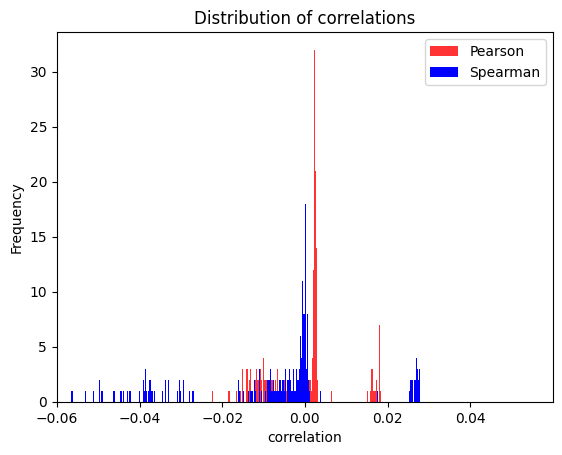

In [33]:
# Histogram of correlations
plt.hist(pearsons, bins=4000, color='red', alpha=0.8, label="Pearson")
plt.hist(spearmans, bins=4000, color='blue', label="Spearman")
plt.xlabel('correlation')
plt.ylabel('Frequency')
plt.title(f'Distribution of correlations')
plt.xticks(np.arange(-0.06, 0.06, 0.02))
plt.xlim(-0.06, 0.06)
plt.legend()
plt.show()

In [34]:
# Decision tree screening

from sklearn.tree import DecisionTreeRegressor

X = df_flattened_windows.iloc[:, 1:]  # all features
y = df_flattened_windows.iloc[:, 0]   # target

results_d1 = {}
results_d2 = {}

# custom depth
d = 10
results_d = {}

save_thr_d1 = []
for col in X.columns:
    tree_d1 = DecisionTreeRegressor(max_depth=1)
    tree_d1.fit(X[[col]], y)  # X[[col]] keeps it as 2D
    score_d1 = tree_d1.score(X[[col]], y)  # R^2 score
    results_d1[col] = score_d1
    save_thr_d1.append((tree_d1.tree_.threshold, tree_d1.tree_.value))
    
    tree_d2 = DecisionTreeRegressor(max_depth=2)
    tree_d2.fit(X[[col]], y)  # note: X[[col]] keeps it as 2D
    score_d2 = tree_d2.score(X[[col]], y)  # R^2 score
    results_d2[col] = score_d2   

    tree_d = DecisionTreeRegressor(max_depth=d)
    tree_d.fit(X[[col]], y)  # note: X[[col]] keeps it as 2D
    score_d = tree_d.score(X[[col]], y)  # R^2 score
    results_d[col] = score_d

In [35]:
n_top = 50

d1_sorted = sorted(results_d1.items(), key=lambda x: x[1], reverse=True)
top_d1 = d1_sorted[:n_top]

d2_sorted = sorted(results_d2.items(), key=lambda x: x[1], reverse=True)
top_d2 = d2_sorted[:n_top]

d_sorted = sorted(results_d.items(), key=lambda x: x[1], reverse=True)
top_d = d_sorted[:n_top]

print(f"Top {n_top} R^2 scores from depth 1, depth 2 and depth {d} decision trees:\n")
print("".ljust(9), "Depth 1".ljust(25), "Depth 2".ljust(25), f"Depth {d}\n")
for i in range(n_top):
    print(f"{i+1}".ljust(4),
          f"{feature_dict[top_d1[i][0]]}".ljust(15), f"{top_d1[i][1]:.3f}".ljust(9),\
          f"{feature_dict[top_d2[i][0]]}".ljust(15), f"{top_d2[i][1]:.3f}".ljust(9),\
          f"{feature_dict[top_d[i][0]]}".ljust(15), f"{top_d[i][1]:.3f}")

Top 50 R^2 scores from depth 1, depth 2 and depth 10 decision trees:

          Depth 1                   Depth 2                   Depth 10

1    l_candle_12     0.012     c_candle_12     0.013     vw_candle_13    0.070
2    c_candle_12     0.011     l_candle_12     0.013     vw_candle_14    0.068
3    vw_candle_12    0.011     o_candle_12     0.012     vw_candle_16    0.063
4    o_candle_12     0.011     c_candle_11     0.012     l_candle_1      0.062
5    c_candle_11     0.011     vw_candle_12    0.012     l_candle_13     0.062
6    l_candle_13     0.010     c_candle_13     0.012     l_candle_9      0.060
7    o_candle_13     0.010     l_candle_17     0.012     vw_candle_15    0.059
8    vw_candle_13    0.010     o_candle_13     0.011     vw_candle_12    0.058
9    c_candle_13     0.010     l_candle_13     0.011     o_candle_11     0.057
10   l_candle_17     0.009     vw_candle_13    0.011     o_candle_13     0.055
11   h_candle_13     0.009     l_candle_11     0.011     c_candle_11

vw, o, h c, l possibly interesting

## Baseline return

In [36]:
# Baseline return
returns = []
for w in windows:
    rtn = (w['c'].iloc[I_SELL_CANDLE] - w['o'].iloc[I_BUY_CANDLE]) / w['o'].iloc[I_BUY_CANDLE]
    returns.append(rtn)
returns = np.array(returns)
baseline = np.mean(returns)
print(f"Mean baseline return (using only initial stock selection filter): {baseline:.10f}")

Mean baseline return (using only initial stock selection filter): 0.0000025749


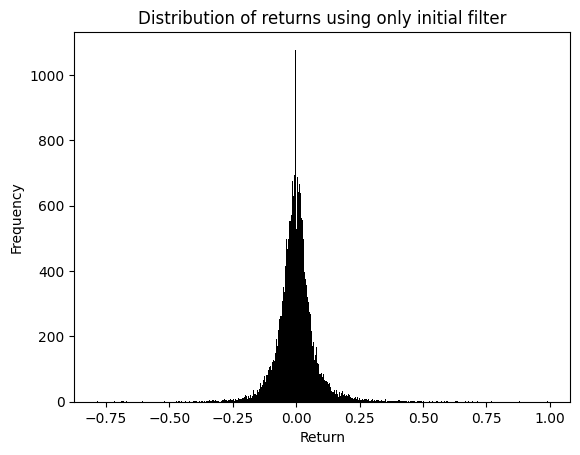

In [37]:
plt.hist(np.array(returns), bins=500, color='black', label="top10")
plt.title("Distribution of returns using only initial filter")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

## Pytorch

Replicating depth 1 decision tree using pytorch to get better understanding of pytorch

In [38]:
feature_index = 1
X = df_flattened_windows.iloc[:, feature_index].values

print(f"Using feature '{feature_dict[feature_index]}' with\nmedian: {np.median(X):.0f}\nmean: {np.mean(X):.0f}\n"
      f"max: {np.max(X):.0f}\nmin: {np.min(X):.0f}\n"
      f"to experiment with pytorch model.")

y = df_flattened_windows.iloc[:, 0].values

Using feature 'v_candle_0' with
median: 14688
mean: 135429
max: 8468282
min: 1
to experiment with pytorch model.


In [39]:
import torch

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print(X_tensor.shape)
print(y_tensor.shape)

torch.Size([23163])
torch.Size([23163])


In [40]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
import torch.nn as nn
import torch.optim as optim
            
# input: feature x
# output: a * s(k(x-t)) + b
#    "x < t = left node"
#    "x > t = right node"
# As k -> inf this should correspond to a decision tree with threshold t
# and predicted value b for left node, a + b for right node.
# If MSE is used for both decision tree and the OneNeuron model below,
# similar results could be expected from both models if k is large.

class OneNeuron(nn.Module):
    def __init__(self, k, t_init=0.5, a_init=0.0, b_init=0.0):
        super().__init__()
        self.k = k # Sigmoid steepness
        self.t = nn.Parameter(torch.tensor(float(t_init)))  # threshold to learn
        self.a = nn.Parameter(torch.tensor(float(a_init)))
        self.b = nn.Parameter(torch.tensor(float(b_init)))  

    def forward(self, x):
        s = torch.sigmoid(self.k * (x - self.t))
        return self.a * s + self.b

steepness = 100
t_init = X_tensor.median()
a_init = 20
b_init = 20

model = OneNeuron(k=steepness, t_init=t_init, a_init=a_init, b_init=b_init)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [42]:
print(f"Training with steepness={steepness}, t_init={t_init}, a_init={a_init}, b_init={b_init}\n")
for epoch in range(40000):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch) % 20000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        print(f"t: {model.t.item():.6f}")
        print(f"left (b): {model.b.item():.6f}")
        print(f"a: {model.a.item():.6f}")
        print(f"right (a+b): {model.a.item() + model.b.item():.6f}")
        print("\n")

Training with steepness=100, t_init=14688.0, a_init=20, b_init=20

Epoch 0, Loss: 1000.0114135742188
t: 14688.009766
left (b): 19.990000
a: 19.990000
right (a+b): 39.980000


Epoch 20000, Loss: 0.00632165651768446
t: 14688.101562
left (b): 0.000478
a: -0.000951
right (a+b): -0.000473




In [47]:
print(f"Parameters after training with steepness={steepness}, t_init={t_init}, left_init (b): {b_init}, right_init (a+b): {a_init+b_init}:\n")
print(f"t: {model.t.item():.6f}")
print(f"Left: {model.b.item():.6f}")
print(f"Right: {model.a.item() + model.b.item():.6f}\n")

print("Corresponding values for depth 1 decision tree:\n")
print(f"Threshold t: {save_thr_d1[0][0][0]}") # i1 = feature, i2 = thresholds, i3 = thr 1st node
print(f"Left node value: {save_thr_d1[0][1][1][0][0]:.7f}")
print(f"Right node value: {save_thr_d1[0][1][2][0][0]:.7f}")

Parameters after training with steepness=100, t_init=5.5, left_init (b): 20, right_init (a+b): 40:

t: 5.500000
Left: 0.042447
Right: -0.000060

Corresponding values for depth 1 decision tree:

Threshold t: 5.5
Left node value: 0.0424470
Right node value: -0.0000598


**Note:** The parameter t barely changes since dL/dt ~ s(1-s) ~ 0 due to the steep Sigmoid. But steep Sigmoid is what we want to approximate depth 1 decision tree. So maybe not so easy to replicate depth 1 decision tree with the OneNeuron model.

Let's see if the left and right predicted values are similar to the decision tree's if we start with the actual threshold of the decision tree, t_init=5.5.

In [44]:
steepness = 100
t_init = 5.5
a_init = 20
b_init = 20

model = OneNeuron(k=steepness, t_init=t_init, a_init=a_init, b_init=b_init)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(50000):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

In [45]:
print(f"Parameters after training with steepness={steepness}, t_init={t_init}, left_init (b): {b_init}, right_init (a+b): {a_init+b_init}:\n")
print(f"t: {model.t.item():.6f}")
print(f"Left: {model.b.item():.6f}")
print(f"Right: {model.a.item() + model.b.item():.6f}\n")

print("True (Decision tree) values:")
print(f"t: {save_thr_d1[0][0][0]}")
print(f"Left: {save_thr_d1[0][1][1][0][0]:.7f}")
print(f"Right: {save_thr_d1[0][1][2][0][0]:.7f}")

Parameters after training with steepness=100, t_init=5.5, left_init (b): 20, right_init (a+b): 40:

t: 5.500000
Left: 0.042447
Right: -0.000060

True (Decision tree) values:
t: 5.5
Left: 0.0424470
Right: -0.0000598


The left and right predicted values are similar when t_init=5.5, which is expected since both models minimize the MSE, and the derivatives w.r.t a and b don't vanish.

## TODO

Engineer features, e.g.,

- Slope of lin.reg on price last n candles

- Slope of lin.reg on vol last n candles

- Fractional distance from vwap to close of signal candle

- Relative volume last n candles compared to m candles earlier

- Dollar amount last n candles

- Fractional distance from close of signal candle to low of last n candles (if signal < 0) or to high of last 20 candles (if signal > 0)

Check correlation between engineered features and target

Experiment with binary target (up = 1, down = 0)

Build models

Test models on future data

## Appendix

The process of collecting candlestick windows was as follows:

1. Daily OHLCV data were downloaded for all U.S. stocks over a one-year period, resulting in approximately 2,000,000 daily summaries.
2. The daily summaries were filtered using the following filter criteria:
- $\text{volume} > 650,000$
- $\text{high} > 1$
- $(\text{high} - \text{low}) / \text{low} > 0.1$


3. For each filtered (stock, day) combination, 1-minute data was downloaded.
4. For the 1-minute data, for each (stock, day) combination, candlesticks with $(\text{close} - \text{open}) / \text{open} \geq 0.04$ or $\leq -0.04$ were identified for every point after the given (stock, day) had satisfied the filter criteria above. For example, if a given (stock, day) had satisfied $\text{volume} > 600000$, $\text{high} > 1$, and $(\text{high} - \text{low}) / \text{low} > 0.1$ at 09:55, candlesticks with $\geq 0.04$ or $\leq-0.04$ were identified for every point from 09:56 and onward (until close of post market).
5. For each such found candlestick, the candlestick itself, 20 candlesticks before, and 5 candlesticks after were aggregated into a window of 26 candlesticks.

**Note:** The point at which the thresholds for the 1-minute data started to be checked was at 09:30. The reason for this was that some of the daily summaries only were for regular hours, so many stocks that satisfied the thresholds during pre-market was not included in the downloaded stocks. Hence, any window collected between 04:00 and 09:30 would have led to selection bias.